In [1]:
import pandas as pd 
from pathlib import Path


data_path = Path('./PrecisionFDA/')
test_df = pd.read_csv( data_path / Path('pyCox_test_input_1000.csv'))

                                                                                                                 
final_df = pd.read_csv( data_path / Path('pyCox_train_input_1000_ICU.csv'))

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper

import torch
import torchtuples as tt

from pycox.datasets import metabric
from pycox.models import CoxCC
from pycox.evaluation import EvalSurv



In [3]:
c = final_df.columns
b = test_df.columns
cols_remove = []
for a in c:
    if a in b:
        cols_remove.append(a)
print(cols_remove)

['Id', '1000126', '1014678', '1043400', '1049221', '1049630', '1049635', '105078', '105585', '106258', '106892', '1091392', '1094107', '1100184', '1114085', '1190795', '1234995', '1359133', '1363309', '1366343', '1367439', '1373463', '141918', '1534809', '1599803', '1601380', '1605257', '1652673', '1659149', '1659263', '1660014', '1665227', '1719286', '1723208', '1729584', '1732136', '1732186', '1734340', '1734919', '1735006', '1736776', '1736854', '1737449', '1740467', '1790099', '1791701', '1803932', '1804799', '1808217', '1809104', '1856546', '1860154', '1860480', '1870230', '1873983', '1946840', '197319', '197361', '197378', '197541', '197591', '197604', '198014', '198031', '198240', '198405', '198767', '199224', '200064', '2001499', '204892', '205532', '205923', '2119714', '2123111', '235389', '241834', '243670', '259255', '308182', '308192', '308971', '309043', '309045', '309097', '309362', '310261', '310325', '310385', '310436', '310798', '310965', '311372', '311700', '311989', 

In [5]:
#final_df = final_df.drop(columns=['VALUE'])
#cols_remove = cols_remove.remove('durration')
cols_remove.append('durration')
cols_remove.append('event')
#final_df = final_df[cols_remove]
#final_df = final_df.drop(columns= 'Unnamed: 0')
df_train = final_df
df_test = df_train.sample(frac=0.2)
df_train = df_train.drop(df_test.index)
df_val = df_train.sample(frac=0.2)
df_train = df_train.drop(df_val.index)
df_train.head()

      
cols = df_train.columns
stand_cols = []
leave_cols = []

i = 1
for i in range(len(cols)):
    if "_" in str(cols[i]):
        leave_cols.append(cols[i])
    else:
        stand_cols.append(cols[i])

stand_cols.remove('Id')
stand_cols.remove('durration')
stand_cols.remove('event')
print(stand_cols)
print(leave_cols)

['1000126', '1014678', '1043400', '1049221', '1049630', '1049635', '105078', '105585', '106258', '106892', '1091392', '1094107', '1100184', '1114085', '1190795', '1234995', '1359133', '1363309', '1366343', '1367439', '1373463', '141918', '1534809', '1599803', '1601380', '1605257', '1652673', '1659149', '1659263', '1660014', '1665227', '1719286', '1723208', '1729584', '1732136', '1732186', '1734340', '1734919', '1735006', '1736776', '1736854', '1737449', '1740467', '1790099', '1791701', '1803932', '1804799', '1808217', '1809104', '1856546', '1860154', '1860480', '1870230', '1873983', '1946840', '197319', '197361', '197378', '197541', '197591', '197604', '198014', '198031', '198240', '198405', '198767', '199224', '200064', '2001499', '204892', '205532', '205923', '2119714', '2123111', '235389', '241834', '243670', '259255', '308182', '308192', '308971', '309043', '309045', '309097', '309362', '310261', '310325', '310385', '310436', '310798', '310965', '311372', '311700', '311989', '31199

In [ ]:
final_df.columns

In [9]:
standardize = [([col], StandardScaler()) for col in stand_cols]
leave = [(col, None) for col in leave_cols]
x_mapper_b = DataFrameMapper(standardize + leave)

standardize = [([col], StandardScaler()) for col in stand_cols]
leave = [(col, None) for col in leave_cols]
x_mapper_a = DataFrameMapper(standardize + leave)
#df_copy = df_train
#df_copy = df_copy.drop(columns='durration')
c_df = final_df
c_df = c_df.drop(columns= {'Id', 'durration','event'})
x_mapper_a.fit(c_df)
x_train = x_mapper_b.fit_transform(df_train).astype('float32')
x_val = x_mapper_b.transform(df_val).astype('float32')
x_test = x_mapper_b.transform(df_test).astype('float32')

In [10]:
print(c_df.columns)

Index(['1000126', '1014678', '1043400', '1049221', '1049630', '1049635',
       '105078', '105585', '106258', '106892',
       ...
       'Proc_76601001', 'Proc_80146002', 'Proc_82078001', 'Proc_85548006',
       'Proc_88039007', 'Proc_88848003', 'Proc_90226004', 'Proc_90407005',
       'Proc_90470006', 'Proc_91602002'],
      dtype='object', length=950)


In [11]:
get_target = lambda df: (df['durration'].values, df['event'].values)
y_train = get_target(df_train)
y_val = get_target(df_val)
durations_test, events_test = get_target(df_test)
val = tt.tuplefy(x_val, y_val)

val.shapes()

val.repeat(2).cat().shapes()

((37692, 950), ((37692,), (37692,)))

In [12]:
in_features = x_train.shape[1]
num_nodes = [100, 100]
out_features = 1
batch_norm = True
dropout = 0.1
output_bias = False

net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm,
                              dropout, output_bias=output_bias)

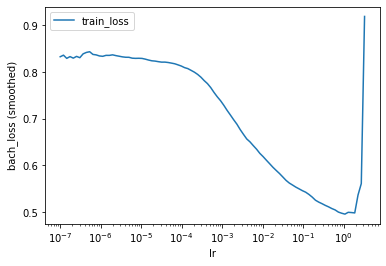

In [13]:
model = CoxCC(net, tt.optim.Adam)
batch_size = 256
lrfinder = model.lr_finder(x_train, y_train, batch_size, tolerance=10)
_ = lrfinder.plot()

In [14]:
lrfinder.get_best_lr()
model.optimizer.set_lr(0.01)

In [15]:
epochs = 512
callbacks = [tt.callbacks.EarlyStopping()]
verbose = True


In [16]:
%%time
log = model.fit(x_train, y_train, batch_size, epochs, callbacks, verbose,
                val_data=val.repeat(10).cat())

0:	[0s / 0s],		train_loss: 0.5370,	val_loss: 0.5352
1:	[0s / 0s],		train_loss: 0.3760,	val_loss: 0.4896
2:	[0s / 0s],		train_loss: 0.3669,	val_loss: 0.3745
3:	[0s / 0s],		train_loss: 0.3644,	val_loss: 0.3267
4:	[0s / 0s],		train_loss: 0.3430,	val_loss: 0.2981
5:	[0s / 0s],		train_loss: 0.3371,	val_loss: 0.8080
6:	[0s / 0s],		train_loss: 0.3529,	val_loss: 0.3135
7:	[0s / 0s],		train_loss: 0.3512,	val_loss: 0.2824
8:	[0s / 0s],		train_loss: 0.3606,	val_loss: 0.2994
9:	[0s / 0s],		train_loss: 0.3248,	val_loss: 0.2730
10:	[0s / 1s],		train_loss: 0.3399,	val_loss: 0.3076
11:	[0s / 1s],		train_loss: 0.3356,	val_loss: 0.3147
12:	[0s / 1s],		train_loss: 0.3367,	val_loss: 0.3082
13:	[0s / 1s],		train_loss: 0.3113,	val_loss: 0.3048
14:	[0s / 1s],		train_loss: 0.3426,	val_loss: 0.3132
15:	[0s / 1s],		train_loss: 0.3403,	val_loss: 0.3087
16:	[0s / 1s],		train_loss: 0.3515,	val_loss: 0.2976
17:	[0s / 1s],		train_loss: 0.3094,	val_loss: 0.2816
18:	[0s / 1s],		train_loss: 0.3198,	val_loss: 0.2899
19:

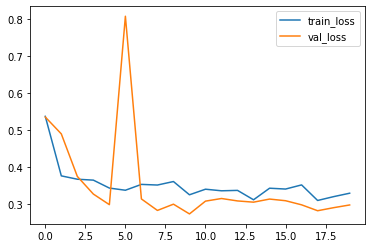

In [17]:
_ = log.plot()

In [18]:
model.partial_log_likelihood(*val).mean()

C:\Users\Konzelc\Anaconda3\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


-5.753672122955322

C:\Users\Konzelc\Anaconda3\lib\site-packages\pycox\models\cox.py:237: RuntimeWarning: overflow encountered in exp
  .assign(expg=np.exp(self.predict(input, batch_size, True, eval_, num_workers=num_workers)))
C:\Users\Konzelc\Anaconda3\lib\site-packages\pycox\models\cox.py:257: RuntimeWarning: overflow encountered in exp
  expg = np.exp(self.predict(input, batch_size, True, eval_, num_workers=num_workers)).reshape(1, -1)


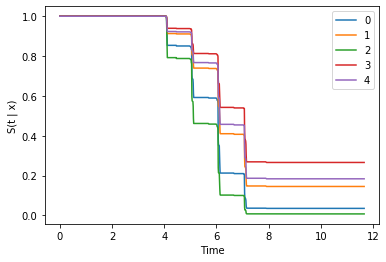

In [32]:
_ = model.compute_baseline_hazards()
surv = model.predict_surv_df(x_test)
surv.iloc[:, 0:5].plot()
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

In [20]:
cd = test_df.columns
co = final_df.columns
dropCols = []
for a in cd:
    if a not in co:
        dropCols.append(a)
print(dropCols)

['1243052', 'Meds_1243052']


(23558, 950)


NameError: name 'pred_x' is not defined

In [22]:
test_df = test_df.drop(columns=dropCols)
cols = test_df.columns
print(cols)

print(test_df.shape)

pred_x = x_mapper_a.transform(test_df).astype('float32')
print(test_df.columns)

surv2 = model.predict_surv_df(pred_x)


Index(['Id', '1000126', '1014678', '1043400', '1049221', '1049630', '1049635',
       '105078', '105585', '106258',
       ...
       'Proc_76601001', 'Proc_80146002', 'Proc_82078001', 'Proc_85548006',
       'Proc_88039007', 'Proc_88848003', 'Proc_90226004', 'Proc_90407005',
       'Proc_90470006', 'Proc_91602002'],
      dtype='object', length=951)
(29040, 951)
Index(['Id', '1000126', '1014678', '1043400', '1049221', '1049630', '1049635',
       '105078', '105585', '106258',
       ...
       'Proc_76601001', 'Proc_80146002', 'Proc_82078001', 'Proc_85548006',
       'Proc_88039007', 'Proc_88848003', 'Proc_90226004', 'Proc_90407005',
       'Proc_90470006', 'Proc_91602002'],
      dtype='object', length=951)


C:\Users\Konzelc\Anaconda3\lib\site-packages\pycox\models\cox.py:257: RuntimeWarning: overflow encountered in exp
  expg = np.exp(self.predict(input, batch_size, True, eval_, num_workers=num_workers)).reshape(1, -1)


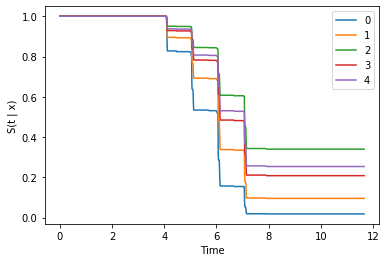

In [23]:
surv2.iloc[:, :5].plot()
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

In [22]:
i = 0
import csv
with open('test_Output_ICU.csv', 'w') as csvfile:
    testwriter = csv.writer(csvfile, delimiter=',')
    for i in range(len(surv2.iloc[0,:])):
        time = ((surv2.iloc[(surv2.iloc[:,i]-0.5).abs().argsort()[:1]][i]).index)[0]
        testwriter.writerow([test_df.iloc[i,0], time])

In [25]:
ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')
ev.concordance_td()

0.8525379505098024

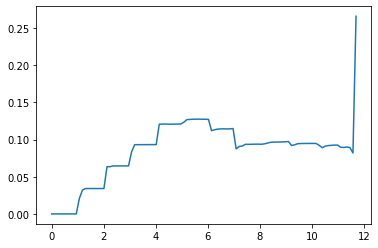

In [26]:
time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)
_ = ev.brier_score(time_grid).plot()

In [27]:
ev.integrated_brier_score(time_grid)

0.08487251981593848

In [28]:
ev.integrated_nbll(time_grid)

0.49391049225886413